<a href="https://colab.research.google.com/github/jxm020202/NLP-CITS4012/blob/main/CITS4012_67.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2024 CITS4012 Project
*Make sure you change the file name with your group id.*

# Readme
Code under experiments are just helper functions, for calculating best optimizer, and attention weights, they do not need to be run.

# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## 1.1 Data load

In [ ]:
import json
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from nltk.util import ngrams
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy.random import seed as set_random_seed


def load_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
        df = pd.DataFrame(data['data'], columns=['sentence', 'aspect', 'polarity'])
    return df

# Function to set random seed for reproducibility
def set_random_seed(seed=112):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

train_data = load_data('/content/train.json')
val_data = load_data('/content/val.json')
test_data = load_data('/content/test.json')

In [ ]:
# To Plot simple model diagrams for Different models
def plot_simple_model(model, file_name):

    plot_model(model, to_file=file_name, show_shapes=False, show_layer_names=False)
    display(Image(file_name))


# Generating Confusion matrix for different models
def plot_confusion_matrix(model, model_name, X_test_text, X_test_pos=None, X_test_aspect=None, y_test=None, class_names=None):

    # Make predictions based on model selected
    if X_test_pos is not None and X_test_aspect is not None:
        y_pred = model.predict([X_test_text, X_test_pos, X_test_aspect])
    elif X_test_pos is not None:
        y_pred = model.predict([X_test_text, X_test_pos])
    else:
        y_pred = model.predict(X_test_text)

    # Convert probability predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # confusion matrix values
    cm = confusion_matrix(y_true_classes, y_pred_classes)


    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


## 1.2 Data Analysis

### 1.2.1 Polarity Count by Train, Validation and test set

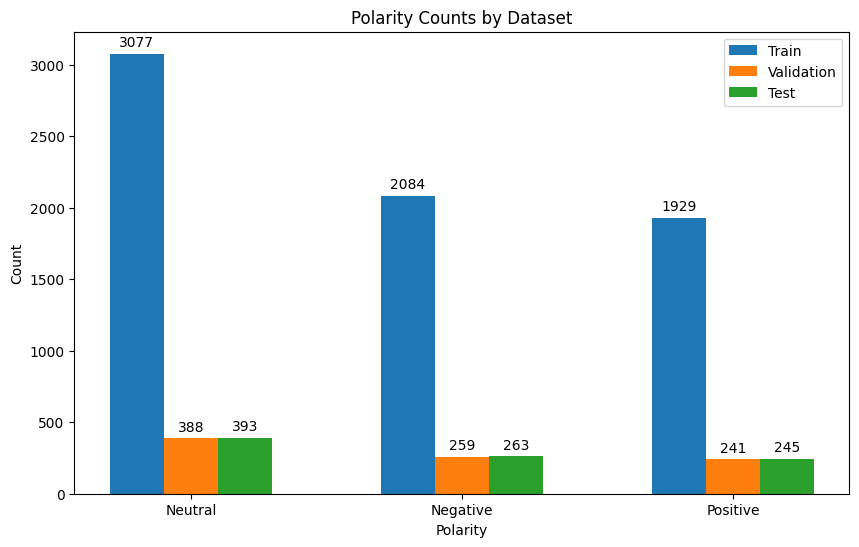

In [ ]:
# Function to count polarity
def count_polarity(df):
    return df['polarity'].value_counts()

# Count polarity in each dataset
train_polarity_counts = count_polarity(train_data)
val_polarity_counts = count_polarity(val_data)
test_polarity_counts = count_polarity(test_data)

all_polarities = ['neutral', 'negative', 'positive']
train_polarity_counts = train_polarity_counts.reindex(all_polarities, fill_value=0)
val_polarity_counts = val_polarity_counts.reindex(all_polarities, fill_value=0)
test_polarity_counts = test_polarity_counts.reindex(all_polarities, fill_value=0)

# Count for plotting
labels = ['Neutral', 'Negative', 'Positive']
train_counts = train_polarity_counts.tolist()
val_counts = val_polarity_counts.tolist()
test_counts = test_polarity_counts.tolist()

# Position and width of bars on x-axis
x = np.arange(len(labels))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, train_counts, width, label='Train')
bars2 = ax.bar(x, val_counts, width, label='Validation')
bars3 = ax.bar(x + width, test_counts, width, label='Test')

ax.set_xlabel('Polarity')
ax.set_ylabel('Count')
ax.set_title('Polarity Counts by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding the counts to display
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.show()

### 1.2.2  Aspect Distribution

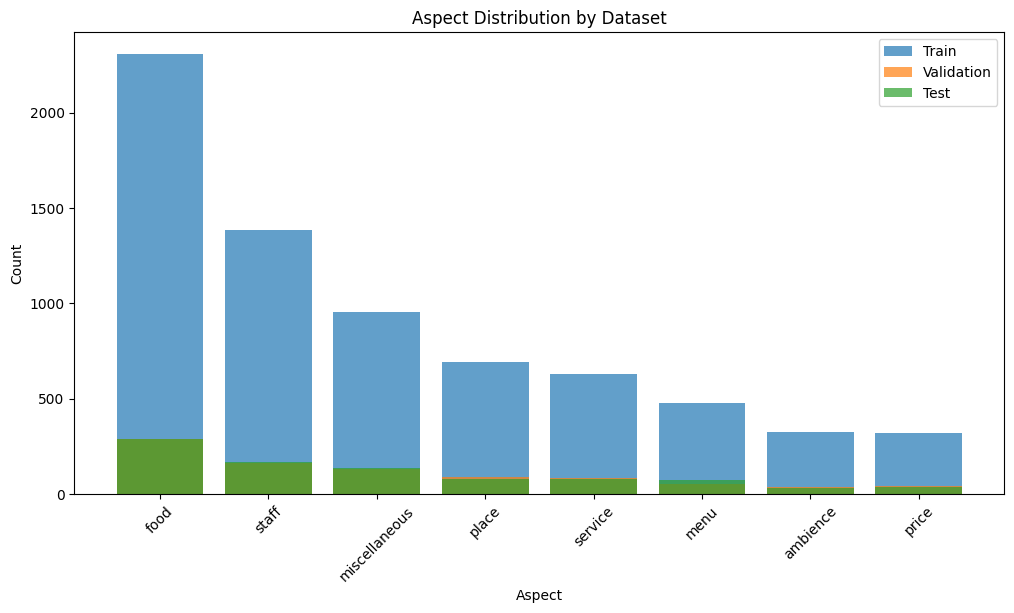

In [ ]:
# Count the occurrence of each aspect
def count_aspects(df):
    return df['aspect'].value_counts()

# Count aspects in each dataset
train_aspect_counts = count_aspects(train_data)
val_aspect_counts = count_aspects(val_data)
test_aspect_counts = count_aspects(test_data)

# Plotting aspect distribution
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(train_aspect_counts.index, train_aspect_counts.values, label='Train', alpha=0.7)
ax.bar(val_aspect_counts.index, val_aspect_counts.values, label='Validation', alpha=0.7)
ax.bar(test_aspect_counts.index, test_aspect_counts.values, label='Test', alpha=0.7)


ax.set_xlabel('Aspect')
ax.set_ylabel('Count')
ax.set_title('Aspect Distribution by Dataset')
ax.legend()

plt.xticks(rotation=45)
plt.show()


### 1.2.3 Sentiment Polarity per Aspect

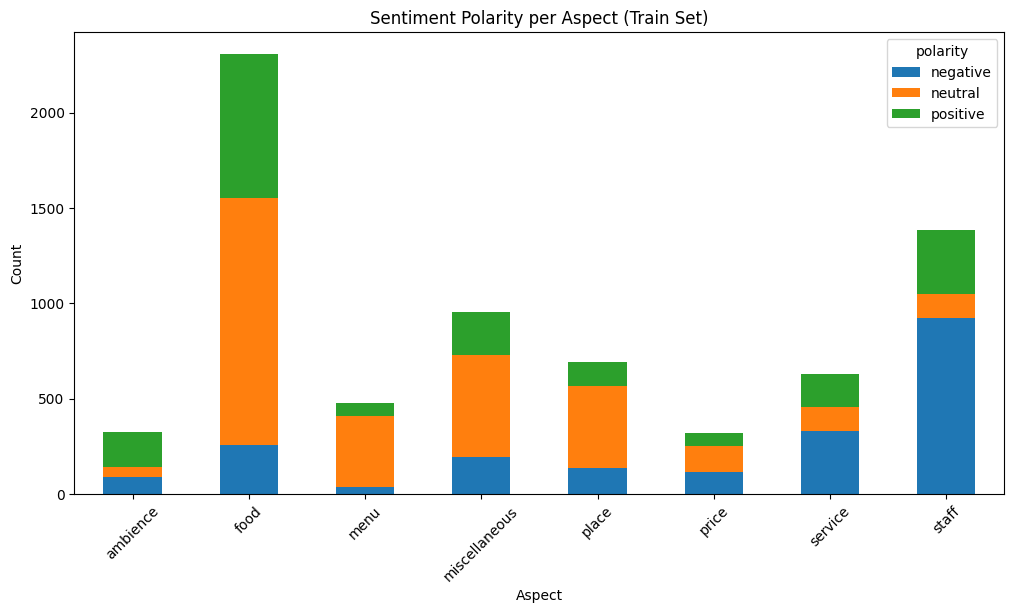

In [ ]:
# Count the occurrence of each polarity for each aspect
def count_polarity_aspect(df):
    return df.groupby('aspect')['polarity'].value_counts().unstack().fillna(0)

# Count polarity for each aspect in each dataset
train_polarity_aspect_counts = count_polarity_aspect(train_data)
val_polarity_aspect_counts = count_polarity_aspect(val_data)
test_polarity_aspect_counts = count_polarity_aspect(test_data)

# Plotting sentiment polarity per aspect for training set
train_polarity_aspect_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Polarity per Aspect (Train Set)')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 1.2.4 Text Length Analysis

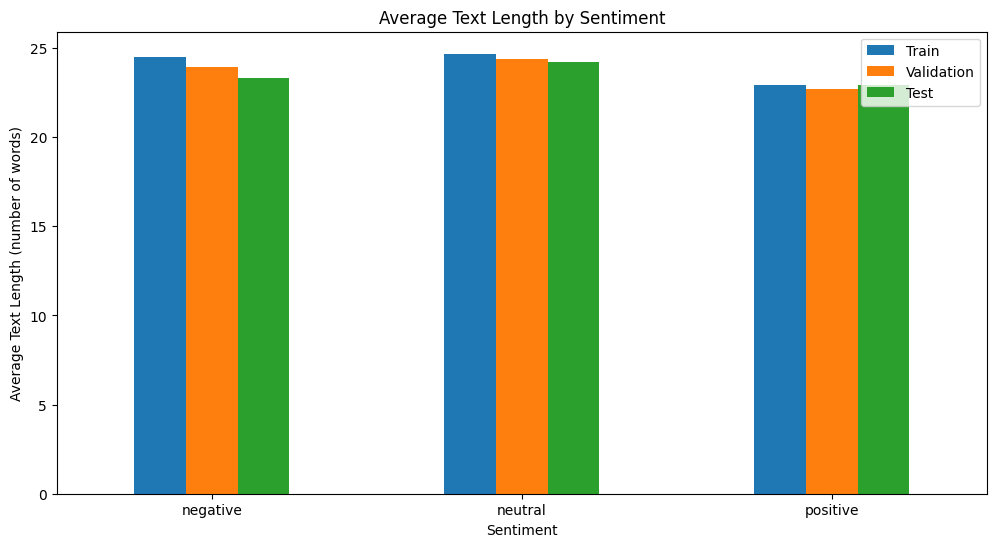

In [ ]:
# Function to calculate text lengths
def calculate_text_lengths(df):
    df['text_length'] = df['sentence'].apply(lambda x: len(x.split()))
    return df

# Calculate text lengths for each dataset
train_data = calculate_text_lengths(train_data)
val_data = calculate_text_lengths(val_data)
test_data = calculate_text_lengths(test_data)

# Function to calculate average text lengths by sentiment
def average_text_lengths(df):
    return df.groupby('polarity')['text_length'].mean()

# Calculate average text lengths by sentiment
train_avg_lengths = average_text_lengths(train_data)
val_avg_lengths = average_text_lengths(val_data)
test_avg_lengths = average_text_lengths(test_data)

# DataFrame for plotting
avg_lengths_df = pd.DataFrame({
    'Train': train_avg_lengths,
    'Validation': val_avg_lengths,
    'Test': test_avg_lengths
})

# Plotting
avg_lengths_df.plot(kind='bar', figsize=(12, 6))
plt.title('Average Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Text Length (number of words)')
plt.xticks(rotation=0)
plt.show()

In [ ]:
print(train_avg_lengths)
print(val_avg_lengths)
print(test_avg_lengths)

polarity
negative    24.485125
neutral     24.677933
positive    22.919129
Name: text_length, dtype: float64
polarity
negative    23.918919
neutral     24.399485
positive    22.688797
Name: text_length, dtype: float64
polarity
negative    23.288973
neutral     24.188295
positive    22.910204
Name: text_length, dtype: float64


## Continuing Pre-processing

In [ ]:


nltk.download('punkt')
nltk.download('stopwords')
# stopwords
stop_words = set(stopwords.words('english'))
# contractions
contractions = {
    "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have",
    "'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have",
    "didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}


# method to clean the text
# lowering
#lemmatization
# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

def textclean(text):
    tokens = word_tokenize(text.lower())
    text = ' '.join([contractions[t] if t in contractions else t for t in tokens])  # Adjusted for contraction handling before splitting
    doc = nlp(text)
    lemmatized = " ".join([token.lemma_ for token in doc])
    filtered_token = [w for w in lemmatized.split() if not w in stop_words and w.isalnum()]  # Splitting lemmatized text
    return " ".join(filtered_token)

train_data['sentence'] = train_data['sentence'].apply(textclean)
val_data['sentence'] = val_data['sentence'].apply(textclean)
test_data['sentence'] = test_data['sentence'].apply(textclean)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2.Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## 2.1 Model 1
**Aspect, Ngrams and SkipGram used followed by Tokenization and Padding**

In [ ]:
# Aspect integration function (specific to your dataset)
def integrate_aspect(text, aspect):
    return f"{text} [ASPECT] {aspect}"


# Function to generate unigrams and bigrams
def generate_ngrams(text, n=2):
    tokens = text.split()
    output = tokens.copy()  # Keep original unigrams
    for i in range(2, n+1):
        output.extend(['_'.join(gram) for gram in ngrams(tokens, i)])
    return " ".join(output)


# Integrate aspect-specific embedding with text
train_data['sentence_with_aspect'] = train_data.apply(lambda row: integrate_aspect(row['sentence'], row['aspect']), axis=1)
val_data['sentence_with_aspect'] = val_data.apply(lambda row: integrate_aspect(row['sentence'], row['aspect']), axis=1)
test_data['sentence_with_aspect'] = test_data.apply(lambda row: integrate_aspect(row['sentence'], row['aspect']), axis=1)

# Apply N-grams generation
train_data['sentence_with_ngrams'] = train_data['sentence_with_aspect'].apply(lambda s: generate_ngrams(s, n=2))
val_data['sentence_with_ngrams'] = val_data['sentence_with_aspect'].apply(lambda s: generate_ngrams(s, n=2))
test_data['sentence_with_ngrams'] = test_data['sentence_with_aspect'].apply(lambda s: generate_ngrams(s, n=2))

# Tokenize and convert to sequences
tokenizer = Tokenizer()

# Fit the tokenizer on combined training and validation data
combined_texts = train_data['sentence_with_ngrams'].tolist() + val_data['sentence_with_ngrams'].tolist()
tokenizer.fit_on_texts(combined_texts)

# Calculate dynamic vocab size (based on unique words actually used)
vocab_size = len(tokenizer.word_index) + 1  # Include space for zero index

max_sequence_length = 30

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['sentence_with_aspect'])
val_sequences = tokenizer.texts_to_sequences(val_data['sentence_with_aspect'])
test_sequences = tokenizer.texts_to_sequences(test_data['sentence_with_aspect'])

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

# Encode and convert polarities to one-hot vectors
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['polarity'])
val_labels = label_encoder.transform(val_data['polarity'])
test_labels = label_encoder.transform(test_data['polarity'])

num_classes = np.max(train_labels) + 1

# 3 sentiment classes
train_labels_onehot = to_categorical(train_labels, num_classes)
val_labels_onehot = to_categorical(val_labels, num_classes)
test_labels_onehot = to_categorical(test_labels, num_classes)



In [ ]:
from gensim.models import Word2Vec

# Aspect integration function (specific to your dataset)
def integrate_aspect(text, aspect):
    return f"{text} [ASPECT] {aspect}"

#Generate N-grams (bigrams)
def generate_ngrams(text, n=2):
    tokens = text.split()
    output = tokens.copy()
    for i in range(2, n+1):
        output.extend(['_'.join(gram) for gram in ngrams(tokens, i)])
    return " ".join(output)

# Integrate aspect information
train_data['sentence_with_aspect'] = train_data.apply(lambda row: f"{row['sentence']} [ASPECT] {row['aspect']}", axis=1)
val_data['sentence_with_aspect'] = val_data.apply(lambda row: f"{row['sentence']} [ASPECT] {row['aspect']}", axis=1)
test_data['sentence_with_aspect'] = test_data.apply(lambda row: f"{row['sentence']} [ASPECT] {row['aspect']}", axis=1)

# Apply N-grams and update text with bigrams
train_data['sentence_with_ngrams'] = train_data['sentence_with_aspect'].apply(lambda s: generate_ngrams(s, n=2))
val_data['sentence_with_ngrams'] = val_data['sentence_with_aspect'].apply(lambda s: generate_ngrams(s, n=2))
test_data['sentence_with_ngrams'] = test_data['sentence_with_aspect'].apply(lambda s: generate_ngrams(s, n=2))

# Skip-gram model to generate word embeddings
sentences = train_data['sentence_with_ngrams'].apply(lambda s: s.split()).tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, sg=1)  # sg=1 for Skip-gram

# dictionary to map words to their embeddings
embedding_dim = 100
vocab_size = len(word2vec_model.wv) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

word_index = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key, start=1)}

for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data['sentence_with_ngrams'])
# Tokenize each data set
train_sequences = tokenizer.texts_to_sequences(train_data['sentence_with_ngrams'])
val_sequences = tokenizer.texts_to_sequences(val_data['sentence_with_ngrams'])
test_sequences = tokenizer.texts_to_sequences(test_data['sentence_with_ngrams'])

max_sequence_length = 30
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

### Model 1 build and compile

In [ ]:
# Define the Bi-LSTM model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],  # Use Skip-gram embeddings
    input_length=max_sequence_length,
    trainable=True
)(input_layer)

bilstm_layer = Bidirectional(LSTM(64, return_sequences=False))(embedding_layer)
output_layer = Dense(num_classes, activation='softmax')(bilstm_layer)  # 3 sentiment classes

model_1_b = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with random seed 112
set_random_seed(112)
model_1_b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1_b.summary()

# ModelCheckpoint to save the best model weights
checkpoint = ModelCheckpoint(
    filepath='best_model_weights_model_1_b.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)




Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 30)]              0         
                                                                 
 embedding_72 (Embedding)    (None, 30, 100)           476300    
                                                                 
 bidirectional_44 (Bidirect  (None, 128)               84480     
 ional)                                                          
                                                                 
 dense_32 (Dense)            (None, 3)                 387       
                                                                 
Total params: 561167 (2.14 MB)
Trainable params: 561167 (2.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training

In [ ]:

model_1_b.fit(train_padded, train_labels_onehot,
          validation_data=(val_padded, val_labels_onehot),
          epochs=10,
          batch_size=64,
          callbacks=[checkpoint])

Epoch 1/10
111/111 [==============================] - ETA: 0s - loss: 0.9739 - accuracy: 0.5343
Epoch 1: val_accuracy improved from -inf to 0.56644, saving model to best_model_weights_model_1_b.h5
111/111 [==============================] - 15s 103ms/step - loss: 0.9739 - accuracy: 0.5343 - val_loss: 0.9162 - val_accuracy: 0.5664
Epoch 2/10
110/111 [============================>.] - ETA: 0s - loss: 0.8711 - accuracy: 0.6050
Epoch 2: val_accuracy improved from 0.56644 to 0.60698, saving model to best_model_weights_model_1_b.h5
111/111 [==============================] - 8s 72ms/step - loss: 0.8714 - accuracy: 0.6051 - val_loss: 0.8546 - val_accuracy: 0.6070
Epoch 3/10
110/111 [============================>.] - ETA: 0s - loss: 0.7811 - accuracy: 0.6527
Epoch 3: val_accuracy improved from 0.60698 to 0.63514, saving model to best_model_weights_model_1_b.h5
111/111 [==============================] - 11s 97ms/step - loss: 0.7805 - accuracy: 0.6522 - val_loss: 0.7922 - val_accuracy: 0.6351
Epoc

## 2.2 Model 2
**Introducing POS tags for better contextual understanding for sentences with aspect information**

In [ ]:
# Initialize LabelEncoder for encoding the 'aspect'
aspect_encoder = LabelEncoder()
train_data['aspect_encoded'] = aspect_encoder.fit_transform(train_data['aspect'])
val_data['aspect_encoded'] = aspect_encoder.transform(val_data['aspect'])
test_data['aspect_encoded'] = aspect_encoder.transform(test_data['aspect'])

# convert to categorical
Y_train_aspect = to_categorical(train_data['aspect_encoded'])
Y_val_aspect = to_categorical(val_data['aspect_encoded'])
Y_test_aspect = to_categorical(test_data['aspect_encoded'])

# Adding part-of-speech (POS) tags to texts
def add_pos_tags(texts):
    pos_texts = []
    for doc in nlp.pipe(texts):
        pos_texts.append(" ".join([token.pos_ for token in doc]))
    return pos_texts

train_pos = add_pos_tags(train_data['sentence'])
val_pos = add_pos_tags(val_data['sentence'])
test_pos = add_pos_tags(test_data['sentence'])

tokenizer = Tokenizer()
pos_tokenizer = Tokenizer()
all_text = pd.concat([train_data['sentence'], val_data['sentence']])
tokenizer.fit_on_texts(all_text)
pos_tokenizer.fit_on_texts(train_pos + val_pos)

max_len = 30 # because after seeing data, we saw that average sentence length is around 20-25

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['sentence']), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data['sentence']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['sentence']), maxlen=max_len)

train_pos_pad = pad_sequences(pos_tokenizer.texts_to_sequences(train_pos), maxlen=max_len)
val_pos_pad = pad_sequences(pos_tokenizer.texts_to_sequences(val_pos), maxlen=max_len)
test_pos_pad = pad_sequences(pos_tokenizer.texts_to_sequences(test_pos), maxlen=max_len)

In [ ]:
#preparing one hot label
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(train_data['polarity'])
Y_val = label_encoder.transform(val_data['polarity'])
Y_test = label_encoder.transform(test_data['polarity'])

num_classes = np.max(Y_train) + 1  # Adding 1 because class indices are zero-based
# convert to categorical
Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_val = to_categorical(Y_val, num_classes=num_classes)
Y_test = to_categorical(Y_test, num_classes=num_classes)

### Model 2 build and compile

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
pos_vocab_size = len(pos_tokenizer.word_index) + 1
word_embedding_dim = 100
pos_embedding_dim = 30

# Define the size of the aspect embedding
aspect_embedding_dim = 30
aspect_vocab_size = len(aspect_encoder.classes_)

# Aspect Input and Embedding layer
aspect_input = Input(shape=(1,))
aspect_embedding = Embedding(aspect_vocab_size, aspect_embedding_dim, trainable=True)(aspect_input)
aspect_embedding = Bidirectional(LSTM(64))(aspect_embedding)  # Using a simple LSTM to process aspect embeddings

# Concatenating aspect embeddings with text and pos embeddings

text_input = Input(shape=(max_len,))
text_embedding = Embedding(vocab_size, word_embedding_dim, trainable=True)(text_input)
text_lstm = Bidirectional(LSTM(64))(text_embedding)

pos_input = Input(shape=(max_len,))
pos_embedding = Embedding(pos_vocab_size, pos_embedding_dim, trainable=True)(pos_input)
pos_lstm = Bidirectional(LSTM(64))(pos_embedding)

concat = concatenate([text_lstm, pos_lstm, aspect_embedding])
output = Dense(num_classes, activation='softmax')(concat)


model_2 = Model(inputs=[text_input, pos_input, aspect_input], outputs=output)

set_random_seed(112)

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

# Setup ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='best_model_weights_model_2.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)


Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_44 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 input_45 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 input_43 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_55 (Embedding)    (None, 30, 100)              542700    ['input_44[0][0]']            
                                                                                           

### Training

In [ ]:
model_2.fit(
    [X_train, train_pos_pad, train_data['aspect_encoded']], Y_train,
    validation_data=([X_val, val_pos_pad, val_data['aspect_encoded']], Y_val),
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint]
)

Epoch 1/10
111/111 [==============================] - ETA: 0s - loss: 0.9734 - accuracy: 0.5240
Epoch 1: val_accuracy improved from -inf to 0.61374, saving model to best_model_weights_model_2.h5
111/111 [==============================] - 30s 155ms/step - loss: 0.9734 - accuracy: 0.5240 - val_loss: 0.8387 - val_accuracy: 0.6137
Epoch 2/10
111/111 [==============================] - ETA: 0s - loss: 0.8202 - accuracy: 0.6324
Epoch 2: val_accuracy improved from 0.61374 to 0.63851, saving model to best_model_weights_model_2.h5
111/111 [==============================] - 15s 135ms/step - loss: 0.8202 - accuracy: 0.6324 - val_loss: 0.7961 - val_accuracy: 0.6385
Epoch 3/10
111/111 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.6787
Epoch 3: val_accuracy improved from 0.63851 to 0.64414, saving model to best_model_weights_model_2.h5
111/111 [==============================] - 17s 158ms/step - loss: 0.7290 - accuracy: 0.6787 - val_loss: 0.7911 - val_accuracy: 0.6441
Epoch 4

In [ ]:
model_2.load_weights('best_model_weights_model_2.h5')
val_accuracy_model_2 = model_2.evaluate([X_val, val_pos_pad, val_data['aspect_encoded']], Y_val)
print("Validation accuracy Model 2:", val_accuracy_model_2[1])

28/28 [==============================] - 1s 18ms/step - loss: 0.8694 - accuracy: 0.6453
Validation accuracy Model 2: 0.6452702879905701


## 2.3 Model 3

### Model 3(a)
**Additive Attention Attention is used after the bidirectional LSTM layer (Bidirectional(LSTM(64, return_sequences=True))). It calculates attention weights over the output of the Bi-LSTM layer. The attention weights are applied before concatenating with the aspect-specific LSTM output.**

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_46 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 input_47 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_57 (Embedding)    (None, 30, 100)              542700    ['input_46[0][0]']            
                                                                                                  
 embedding_58 (Embedding)    (None, 30, 30)               480       ['input_47[0][0]']            
                                                                                           

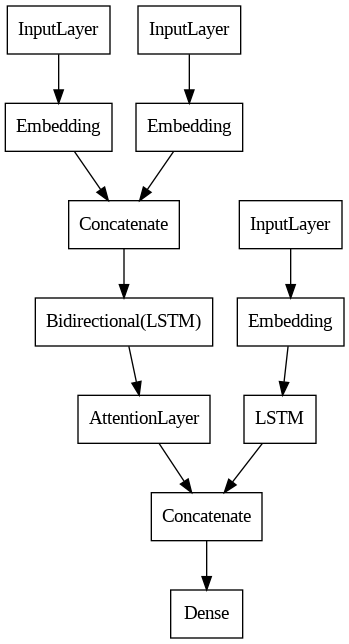

In [ ]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, concatenate, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from keras.layers import Layer, InputSpec
import keras.backend as K

#defining Attention layers

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='context_vector',
                                 shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, K.expand_dims(self.u))
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# Define the sizes for vocabulary, embeddings, and sequence lengths
vocab_size = len(tokenizer.word_index) + 1
pos_vocab_size = len(pos_tokenizer.word_index) + 1
word_embedding_dim = 100
pos_embedding_dim = 30
max_len = 30
aspect_embedding_dim = 30
aspect_vocab_size = len(aspect_encoder.classes_)
num_classes = len(label_encoder.classes_)

# Define the inputs
text_input = Input(shape=(max_len,))
pos_input = Input(shape=(max_len,))
aspect_input = Input(shape=(1,))

# Embedding layers
text_embedding = Embedding(vocab_size, word_embedding_dim, trainable=True)(text_input)
pos_embedding = Embedding(pos_vocab_size, pos_embedding_dim, trainable=True)(pos_input)
aspect_embedding = Embedding(aspect_vocab_size, aspect_embedding_dim, trainable=True)(aspect_input)

# Concatenate text and POS embeddings
text_pos_embedding = concatenate([text_embedding, pos_embedding])

# Bi-LSTM for main text with POS embeddings
text_lstm = Bidirectional(LSTM(64, return_sequences=True))(text_pos_embedding)

# Attention layer for text
attention_layer = AttentionLayer()(text_lstm)

# Aspect LSTM
aspect_lstm = LSTM(64)(aspect_embedding)

# Concatenate all features
concat = concatenate([attention_layer, aspect_lstm])

# Dense layers and output
output = Dense(num_classes, activation='softmax')(concat)

# Model definition
model_3_a = Model(inputs=[text_input, pos_input, aspect_input], outputs=output)

# Compile the model
set_random_seed(112)
model_3_a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_3_a.summary()


checkpoint = ModelCheckpoint(
    filepath='best_model_weights_3_a.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

plot_simple_model(model_3_a, 'Flow_model_3_a.png')

#### Training

In [ ]:
# Assuming X_train, X_val, X_test, train_pos_pad, val_pos_pad, test_pos_pad, Y_train, Y_val, Y_test are defined
history = model_3_a.fit(
    [X_train, train_pos_pad, train_data['aspect_encoded']], Y_train,
    validation_data=([X_val, val_pos_pad, val_data['aspect_encoded']], Y_val),
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint]
)

Epoch 1/10
111/111 [==============================] - ETA: 0s - loss: 0.9896 - accuracy: 0.5103
Epoch 1: val_accuracy improved from -inf to 0.59234, saving model to best_model_weights_3_a.h5
111/111 [==============================] - 20s 109ms/step - loss: 0.9896 - accuracy: 0.5103 - val_loss: 0.8445 - val_accuracy: 0.5923
Epoch 2/10
111/111 [==============================] - ETA: 0s - loss: 0.8204 - accuracy: 0.6313
Epoch 2: val_accuracy improved from 0.59234 to 0.65203, saving model to best_model_weights_3_a.h5
111/111 [==============================] - 12s 103ms/step - loss: 0.8204 - accuracy: 0.6313 - val_loss: 0.7920 - val_accuracy: 0.6520
Epoch 3/10
111/111 [==============================] - ETA: 0s - loss: 0.7280 - accuracy: 0.6774
Epoch 3: val_accuracy did not improve from 0.65203
111/111 [==============================] - 13s 122ms/step - loss: 0.7280 - accuracy: 0.6774 - val_loss: 0.8078 - val_accuracy: 0.6419
Epoch 4/10
111/111 [==============================] - ETA: 0s - lo

### Model 3(b)
**This architecture combines various advanced techniques, including multi-head attention and aspect-guided attention, to effectively capture the relationships between text, POS tags, and aspect information for aspect-based sentiment analysis. Key Changes: Multi-Head Attention: Added a multi-head attention layer after the Bi-LSTM layer. This allows the model to attend to different parts of the sequence simultaneously, potentially capturing more complex patterns.**

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 input_50 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_60 (Embedding)    (None, 30, 100)              542700    ['input_49[0][0]']            
                                                                                                  
 embedding_61 (Embedding)    (None, 30, 30)               480       ['input_50[0][0]']            
                                                                                           

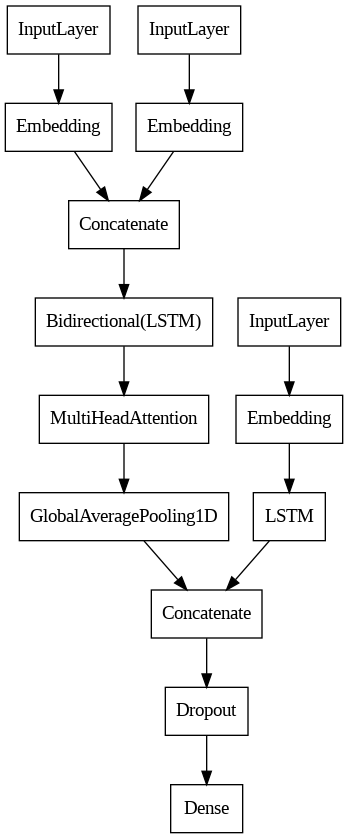

In [ ]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, concatenate, Dense, MultiHeadAttention, GlobalAveragePooling1D, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# Define the sizes for vocabulary, embeddings, and sequence lengths
vocab_size = len(tokenizer.word_index) + 1
pos_vocab_size = len(pos_tokenizer.word_index) + 1
word_embedding_dim = 100
pos_embedding_dim = 30
max_len = 30
aspect_embedding_dim = 30
aspect_vocab_size = len(aspect_encoder.classes_)
num_classes = len(label_encoder.classes_)

# Define the inputs
text_input = Input(shape=(max_len,))
pos_input = Input(shape=(max_len,))
aspect_input = Input(shape=(1,))

# Embedding layers
text_embedding = Embedding(vocab_size, word_embedding_dim, trainable=True)(text_input)
pos_embedding = Embedding(pos_vocab_size, pos_embedding_dim, trainable=True)(pos_input)
aspect_embedding = Embedding(aspect_vocab_size, aspect_embedding_dim, trainable=True)(aspect_input)

# Concatenate text and POS embeddings
text_pos_embedding = concatenate([text_embedding, pos_embedding])

# Bi-LSTM for main text with POS embeddings
text_lstm = Bidirectional(LSTM(64, return_sequences=True))(text_pos_embedding)

# Multi-Head Attention layer for text
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(text_lstm, text_lstm)

# Apply Global Average Pooling to attention output
attention_pooled = GlobalAveragePooling1D()(attention_output)

# Aspect LSTM
aspect_lstm = LSTM(64)(aspect_embedding)

# Concatenate all features
concat = concatenate([attention_pooled, aspect_lstm])

# Dropout for regularization
concat = Dropout(0.5)(concat)

# Dense layers and output
output = Dense(num_classes, activation='softmax')(concat)

# Model definition
model_3_b = Model(inputs=[text_input, pos_input, aspect_input], outputs=output)

# Compile the model
set_random_seed(112)
model_3_b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_3_b.summary()



checkpoint = ModelCheckpoint(
    filepath='best_model_weights_model_3_b.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

plot_simple_model(model_3_b, 'Flow_model_3_b.png')


#### Training

In [ ]:
# Assuming X_train, X_val, X_test, train_pos_pad, val_pos_pad, test_pos_pad, Y_train, Y_val, Y_test are defined
history = model_3_b.fit(
    [X_train, train_pos_pad, train_data['aspect_encoded']], Y_train,
    validation_data=([X_val, val_pos_pad, val_data['aspect_encoded']], Y_val),
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint]
)

Epoch 1/10
111/111 [==============================] - ETA: 0s - loss: 1.0040 - accuracy: 0.4992
Epoch 1: val_accuracy improved from -inf to 0.62725, saving model to best_model_weights_model_3_b.h5
111/111 [==============================] - 28s 183ms/step - loss: 1.0040 - accuracy: 0.4992 - val_loss: 0.8614 - val_accuracy: 0.6273
Epoch 2/10
111/111 [==============================] - ETA: 0s - loss: 0.8631 - accuracy: 0.6097
Epoch 2: val_accuracy did not improve from 0.62725
111/111 [==============================] - 17s 154ms/step - loss: 0.8631 - accuracy: 0.6097 - val_loss: 0.8325 - val_accuracy: 0.6081
Epoch 3/10
111/111 [==============================] - ETA: 0s - loss: 0.7943 - accuracy: 0.6478
Epoch 3: val_accuracy improved from 0.62725 to 0.65428, saving model to best_model_weights_model_3_b.h5
111/111 [==============================] - 21s 190ms/step - loss: 0.7943 - accuracy: 0.6478 - val_loss: 0.7977 - val_accuracy: 0.6543
Epoch 4/10
111/111 [==============================] - 

### Model 3(c)

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_54 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_65 (Embedding)    (None, 1, 30)                240       ['input_54[0][0]']            
                                                                                                  
 flatten (Flatten)           (None, 30)                   0         ['embedding_65[0][0]']        
                                                                                                  
 input_52 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                           

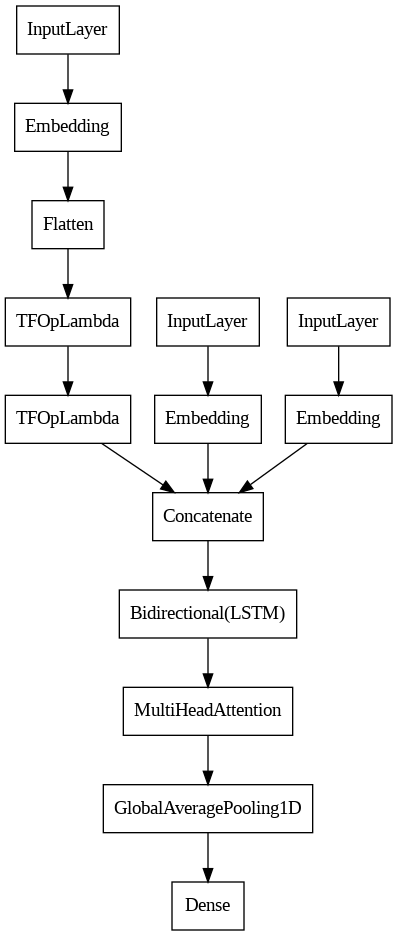

In [ ]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, concatenate, Dense, MultiHeadAttention, GlobalAveragePooling1D, Flatten, Dropout
from keras.models import Model
import numpy as np
import keras.backend as K

# Define the sizes for vocabulary, embeddings, and sequence lengths
vocab_size = len(tokenizer.word_index) + 1
pos_vocab_size = len(pos_tokenizer.word_index) + 1
word_embedding_dim = 100
pos_embedding_dim = 30
max_len = 30
aspect_embedding_dim = 30
aspect_vocab_size = len(aspect_encoder.classes_)
num_classes = len(label_encoder.classes_)
aspect_input_dim = 1  # This should match the dimension of your aspect-specific input

# Define the input layers
text_input = Input(shape=(max_len,))
pos_input = Input(shape=(max_len,))
aspect_input = Input(shape=(aspect_input_dim,))

# Embedding layers
word_embedding_layer = Embedding(vocab_size, word_embedding_dim, input_length=max_len)
pos_embedding_layer = Embedding(pos_vocab_size, pos_embedding_dim, input_length=max_len)
aspect_embedding_layer = Embedding(aspect_vocab_size, aspect_embedding_dim)

word_embedding = word_embedding_layer(text_input)
pos_embedding = pos_embedding_layer(pos_input)
aspect_embedding = aspect_embedding_layer(aspect_input)

# Flatten the aspect embedding
aspect_embedding_flat = Flatten()(aspect_embedding)

# Repeat the aspect embedding to match the sequence length
aspect_embedding_repeated = K.repeat(aspect_embedding_flat, max_len)

# Concatenate word, POS, and aspect embeddings
embedded_input = concatenate([word_embedding, pos_embedding, aspect_embedding_repeated])

# Bi-LSTM layer
bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(embedded_input)

# Multi-Head Attention layer
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(bi_lstm, bi_lstm)

# Apply Global Average Pooling to attention output
attention_pooled = GlobalAveragePooling1D()(attention_output)

# Dense layers and output
output = Dense(num_classes, activation='softmax')(attention_pooled)

# Model definition
model_3_c = Model(inputs=[text_input, pos_input, aspect_input], outputs=output)

# Compile the model
set_random_seed(112)
model_3_c.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_3_c.summary()

checkpoint = ModelCheckpoint(
    filepath='best_model_weights_model_3_c.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

plot_simple_model(model_3_c, 'Flow_model_3_c.png')

#### Training

In [ ]:
history = model_3_c.fit(
    [X_train, train_pos_pad, train_data['aspect_encoded']], Y_train,
    validation_data=([X_val, val_pos_pad, val_data['aspect_encoded']], Y_val),
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint]
)

Epoch 1/10
111/111 [==============================] - ETA: 0s - loss: 0.9274 - accuracy: 0.5780
Epoch 1: val_accuracy improved from -inf to 0.61149, saving model to best_model_weights_model_3_c.h5
111/111 [==============================] - 24s 166ms/step - loss: 0.9274 - accuracy: 0.5780 - val_loss: 0.8321 - val_accuracy: 0.6115
Epoch 2/10
111/111 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.6430
Epoch 2: val_accuracy improved from 0.61149 to 0.65991, saving model to best_model_weights_model_3_c.h5
111/111 [==============================] - 18s 161ms/step - loss: 0.8181 - accuracy: 0.6430 - val_loss: 0.7967 - val_accuracy: 0.6599
Epoch 3/10
111/111 [==============================] - ETA: 0s - loss: 0.7256 - accuracy: 0.6829
Epoch 3: val_accuracy did not improve from 0.65991
111/111 [==============================] - 19s 175ms/step - loss: 0.7256 - accuracy: 0.6829 - val_loss: 0.7826 - val_accuracy: 0.6498
Epoch 4/10
111/111 [==============================] - 

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

##3.1 Model 1

###Accuracy

In [ ]:
# Assuming 'best_model_weights.h5' contains the saved model weights
model_1_b.load_weights('best_model_weights_model_1_b.h5')

# Evaluate the model on the test set
test_accuracy_1_b = model_1_b.evaluate(test_padded, test_labels_onehot, verbose=0)

print("Test accuracy:", test_accuracy_1_b[1])



Test accuracy: 0.6104328632354736


###Confusion matrix

29/29 [==============================] - 1s 10ms/step


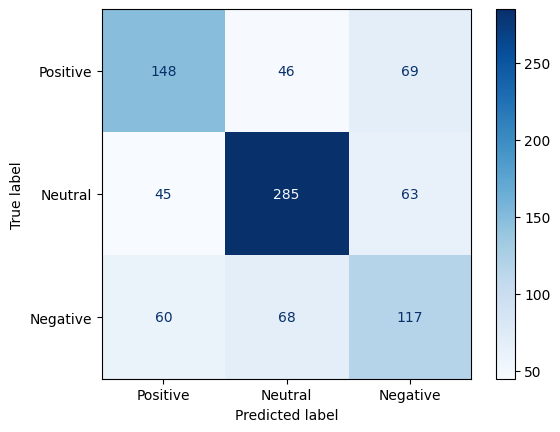

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Predict the class probabilities for the validation set
test_predictions = model_1_b.predict(test_padded)

# Convert the probabilities to class labels
test_pred_labels = test_predictions.argmax(axis=1)

# Convert validation labels from one-hot encoded to class labels
test_true_labels = test_labels_onehot.argmax(axis=1)

# Generate the confusion matrix
cm_1 = confusion_matrix(test_true_labels, test_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.show()



In [ ]:
print(cm_1)

[[148  46  69]
 [ 45 285  63]
 [ 60  68 117]]


### Ablation Study

####BaseModel

In [ ]:

# Define vocabulary sizes and embedding dimensions
vocab_size = len(tokenizer.word_index) + 1
pos_vocab_size = len(pos_tokenizer.word_index) + 1
word_embedding_dim = 100
pos_embedding_dim = 30
aspect_embedding_dim = 30
aspect_vocab_size = len(aspect_encoder.classes_)

# Aspect Input and Embedding layer
aspect_input = Input(shape=(1,), name='aspect_input')
aspect_embedding = Embedding(aspect_vocab_size, aspect_embedding_dim, trainable=True)(aspect_input)
aspect_embedding = LSTM(64)(aspect_embedding)  # Using a simple LSTM to process aspect embeddings

# Text Input and Embedding layer
text_input = Input(shape=(max_len,), name='text_input')
text_embedding = Embedding(vocab_size, word_embedding_dim, trainable=True)(text_input)
text_lstm = LSTM(64)(text_embedding)

# Concatenate text LSTM output with aspect embedding
concat = concatenate([text_lstm, aspect_embedding])
output = Dense(num_classes, activation='softmax')(concat)

# Define the model
model_1_baseline_lstm = Model(inputs=[text_input, aspect_input], outputs=output)

# Compile the model
model_1_baseline_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_1_baseline_lstm.fit(
    [X_train, train_data['aspect_encoded']], Y_train,
    validation_data=([X_val, val_data['aspect_encoded']], Y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
111/111 [==============================] - 11s 54ms/step - loss: 0.9911 - accuracy: 0.5047 - val_loss: 0.8429 - val_accuracy: 0.6081
Epoch 2/10
111/111 [==============================] - 7s 63ms/step - loss: 0.8232 - accuracy: 0.6286 - val_loss: 0.7937 - val_accuracy: 0.6565
Epoch 3/10
111/111 [==============================] - 5s 46ms/step - loss: 0.7240 - accuracy: 0.6814 - val_loss: 0.7906 - val_accuracy: 0.6475
Epoch 4/10
111/111 [==============================] - 5s 45ms/step - loss: 0.6683 - accuracy: 0.6976 - val_loss: 0.8230 - val_accuracy: 0.6182
Epoch 5/10
111/111 [==============================] - 8s 69ms/step - loss: 0.6360 - accuracy: 0.7118 - val_loss: 0.8544 - val_accuracy: 0.6318
Epoch 6/10
111/111 [==============================] - 5s 45ms/step - loss: 0.6169 - accuracy: 0.7159 - val_loss: 0.8552 - val_accuracy: 0.6419
Epoch 7/10
111/111 [==============================] - 7s 67ms/step - loss: 0.5993 - accuracy: 0.7264 - val_loss: 0.8660 - val_accuracy: 0.626

####BaseModel-2

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
pos_vocab_size = len(pos_tokenizer.word_index) + 1
word_embedding_dim = 100
pos_embedding_dim = 30

# Define the size of the aspect embedding
aspect_embedding_dim = 30
aspect_vocab_size = len(aspect_encoder.classes_)

# Aspect Input and Embedding layer
aspect_input = Input(shape=(1,))
aspect_embedding = Embedding(aspect_vocab_size, aspect_embedding_dim, trainable=True)(aspect_input)
aspect_embedding = Bidirectional(LSTM(64))(aspect_embedding)  # Using a simple LSTM to process aspect embeddings

# Concatenating aspect embeddings with text and pos embeddings

text_input = Input(shape=(max_len,))
text_embedding = Embedding(vocab_size, word_embedding_dim, trainable=True)(text_input)
text_lstm = Bidirectional(LSTM(64))(text_embedding)

concat = concatenate([text_lstm, aspect_embedding])
output = Dense(num_classes, activation='softmax')(concat)


model_1_baseline_BiLSTM = Model(inputs=[text_input, aspect_input], outputs=output)
set_random_seed(112)
model_1_baseline_BiLSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_1_baseline_BiLSTM.fit(
    [X_train, train_data['aspect_encoded']], Y_train,
    validation_data=([X_val, val_data['aspect_encoded']], Y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
111/111 [==============================] - 22s 107ms/step - loss: 0.9781 - accuracy: 0.5145 - val_loss: 0.8408 - val_accuracy: 0.6104
Epoch 2/10
111/111 [==============================] - 11s 100ms/step - loss: 0.8195 - accuracy: 0.6354 - val_loss: 0.7938 - val_accuracy: 0.6430
Epoch 3/10
111/111 [==============================] - 11s 100ms/step - loss: 0.7297 - accuracy: 0.6825 - val_loss: 0.7901 - val_accuracy: 0.6363
Epoch 4/10
111/111 [==============================] - 9s 77ms/step - loss: 0.6708 - accuracy: 0.6972 - val_loss: 0.8095 - val_accuracy: 0.6295
Epoch 5/10
111/111 [==============================] - 11s 100ms/step - loss: 0.6384 - accuracy: 0.7150 - val_loss: 0.8479 - val_accuracy: 0.6318
Epoch 6/10
111/111 [==============================] - 11s 100ms/step - loss: 0.6167 - accuracy: 0.7182 - val_loss: 0.8859 - val_accuracy: 0.6385
Epoch 7/10
111/111 [==============================] - 9s 81ms/step - loss: 0.5999 - accuracy: 0.7255 - val_loss: 0.8701 - val_accura

####Aspect-N-gram with BiLSTM

In [ ]:
# Define the Bi-LSTM model
embedding_dim = 100
hidden_dim = 64

input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer)
bilstm_layer = Bidirectional(LSTM(hidden_dim, return_sequences=False))(embedding_layer)
output_layer = Dense(num_classes, activation='softmax')(bilstm_layer)  # For three classes: positive, negative, neutral

model_1_a = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
set_random_seed(112)
model_1_a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1_a.summary()

# Training the model with early stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# Setup ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='best_model_weights_model_1_a.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)
model_1_a.fit(train_padded, train_labels_onehot,
          validation_data=(val_padded, val_labels_onehot),
          epochs=10,
          batch_size=64,
          callbacks=[checkpoint])

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 30)]              0         
                                                                 
 embedding_70 (Embedding)    (None, 30, 100)           542700    
                                                                 
 bidirectional_43 (Bidirect  (None, 128)               84480     
 ional)                                                          
                                                                 
 dense_31 (Dense)            (None, 3)                 387       
                                                                 
Total params: 627567 (2.39 MB)
Trainable params: 627567 (2.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
110/111 [============================>.] - ETA: 0s - loss: 0.9846 - accuracy:

####Visualization

In [ ]:
model_lstm_validation_accuracy = model_1_baseline_lstm.evaluate([X_test, test_data['aspect_encoded']], Y_test)
print(f"Model with LSTM validation Accuracy: {model_lstm_validation_accuracy[1]}")

model_BiLSTM_validation_accuracy = model_1_baseline_BiLSTM.evaluate([X_test, test_data['aspect_encoded']], Y_test)
print(f"Model with validation with BiLSTM Accuracy: {model_BiLSTM_validation_accuracy[1]}")

model_1_b.load_weights('best_model_weights_model_1_b.h5')
Validation_accuracy_Model_1 = model_1_b.evaluate(test_padded, test_labels_onehot, verbose=0)
print(f"Validation_accuracy_Model_1_b :", Validation_accuracy_Model_1[1])

29/29 [==============================] - 0s 8ms/step - loss: 0.9469 - accuracy: 0.6393
Model with LSTM validation Accuracy: 0.6392896771430969
29/29 [==============================] - 0s 12ms/step - loss: 0.9551 - accuracy: 0.6337
Model with validation with BiLSTM Accuracy: 0.6337403059005737
Validation_accuracy_Model_1_b : 0.6104328632354736


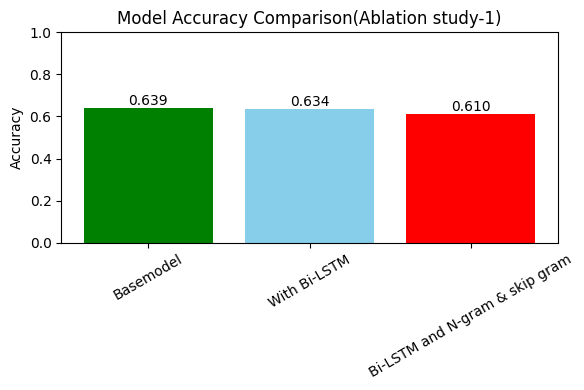

In [ ]:
models = [
    'Basemodel',
    'With Bi-LSTM',
    'Bi-LSTM and N-gram & skip gram'
]
accuracies = [model_lstm_validation_accuracy[1], model_BiLSTM_validation_accuracy[1], Validation_accuracy_Model_1[1]]


# Create the bar plot
plt.figure(figsize=(6, 4))  # Increase the figure size for better spacing
bars = plt.bar(models, accuracies, color=['green', 'skyblue', 'red'])

# Add accuracy labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom'
    )

plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
plt.xlabel('')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison(Ablation study-1)')
plt.xticks(rotation=30, ha='center')  # Rotate x-axis labels
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

##3.2 Model 2

###Accuracy

In [ ]:
# Update the loading and evaluation code to include aspect data
model_2.load_weights('best_model_weights_model_2.h5')

# You need to provide the aspect data as well in the evaluation
test_accuracy_2 = model_2.evaluate([X_test, test_pos_pad, test_data['aspect_encoded']], Y_test)
print("Test accuracy Model 2:", test_accuracy_2[1])

29/29 [==============================] - 1s 31ms/step - loss: 0.8724 - accuracy: 0.6426
Test accuracy Model 2: 0.6426193118095398


###Confusion Matrix

29/29 [==============================] - 3s 19ms/step


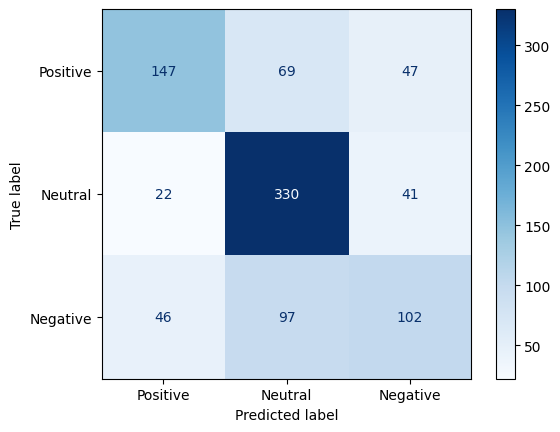

In [ ]:
# Predict the class probabilities for the test set
test_predictions = model_2.predict([X_test, test_pos_pad, test_data['aspect_encoded']])

# Convert the probabilities to class labels
test_pred_labels = test_predictions.argmax(axis=1)

# Convert test labels from one-hot encoded to class labels
test_true_labels = Y_test.argmax(axis=1)

# Generate the confusion matrix
cm_2 = confusion_matrix(test_true_labels, test_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(cm_2)

[[147  69  47]
 [ 22 330  41]
 [ 46  97 102]]


###Ablation Study

In [ ]:
val_accuracy_model_2 = model_2.evaluate([X_val, val_pos_pad, val_data['aspect_encoded']], Y_val)
print("Validation accuracy Model 2:", val_accuracy_model_2[1])

28/28 [==============================] - 1s 19ms/step - loss: 0.8694 - accuracy: 0.6453
Validation accuracy Model 2: 0.6452702879905701


####Visualization

28/28 [==============================] - 1s 19ms/step - loss: 0.8694 - accuracy: 0.6453
Validation accuracy Model 2: 0.6452702879905701


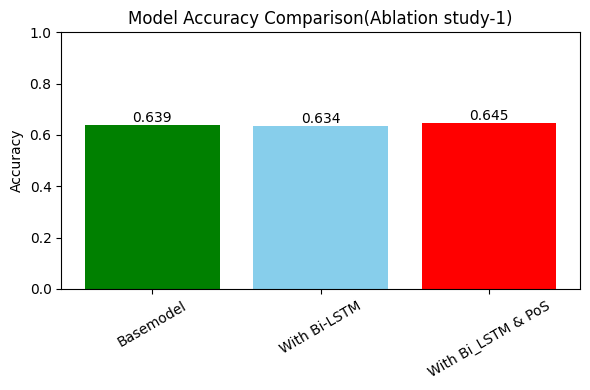

In [ ]:
val_accuracy_model_2 = model_2.evaluate([X_val, val_pos_pad, val_data['aspect_encoded']], Y_val)
print("Validation accuracy Model 2:", val_accuracy_model_2[1])

models = [
    'Basemodel',
    'With Bi-LSTM',
    'With Bi_LSTM & PoS',
]
accuracies = [model_lstm_validation_accuracy[1], model_BiLSTM_validation_accuracy[1], val_accuracy_model_2[1]]


# Create the bar plot
plt.figure(figsize=(6, 4))  # Increase the figure size for better spacing
bars = plt.bar(models, accuracies, color=['green', 'skyblue', 'red'])

# Add accuracy labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom'
    )

plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
plt.xlabel('')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison(Ablation study-1)')
plt.xticks(rotation=30, ha='center')  # Rotate x-axis labels
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

##3.3 Model 3

Accuracy

#### Accuracy (a), (b) and (c)

In [ ]:
# Load the best model weights
model_3_a.load_weights('best_model_weights_3_a.h5')

# Evaluate the model on the test data
test_accuracy_3_a = model_3_a.evaluate([X_test, test_pos_pad, test_data['aspect_encoded']], Y_test)
print("Test accuracy:", test_accuracy_3_a[1])

29/29 [==============================] - 0s 15ms/step - loss: 0.7996 - accuracy: 0.6371
Test accuracy: 0.6370699405670166


In [ ]:
# Load the best model weights
model_3_b.load_weights('best_model_weights_model_3_b.h5')

# Evaluate the model on the test data
test_accuracy_3_b = model_3_b.evaluate([X_test, test_pos_pad, test_data['aspect_encoded']], Y_test)
print("Test accuracy:", test_accuracy_3_b[1])

29/29 [==============================] - 1s 23ms/step - loss: 0.7892 - accuracy: 0.6459
Test accuracy: 0.6459489464759827


In [ ]:
# Update the loading and evaluation code to include aspect data
model_3_c.load_weights('best_model_weights_model_3_c.h5')

# You need to provide the aspect data as well in the evaluation
test_accuracy = model_3_c.evaluate([X_test, test_pos_pad, test_data['aspect_encoded']], Y_test)
print("Test accuracy:", test_accuracy[1])

29/29 [==============================] - 1s 33ms/step - loss: 0.9318 - accuracy: 0.6337
Test accuracy: 0.6337403059005737


###Confusion Matrix (a),(b) and (c)

29/29 [==============================] - 2s 24ms/step


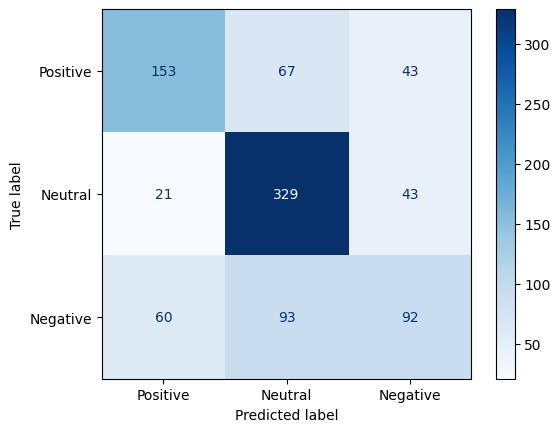

In [ ]:
# Predict the class probabilities for the test set
test_predictions = model_3_a.predict([X_test, test_pos_pad, test_data['aspect_encoded']])

# Convert the probabilities to class labels
test_pred_labels = test_predictions.argmax(axis=1)

# Convert test labels from one-hot encoded to class labels
test_true_labels = Y_test.argmax(axis=1)

# Generate the confusion matrix
cm_3_a = confusion_matrix(test_true_labels, test_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_3_a, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

29/29 [==============================] - 2s 23ms/step


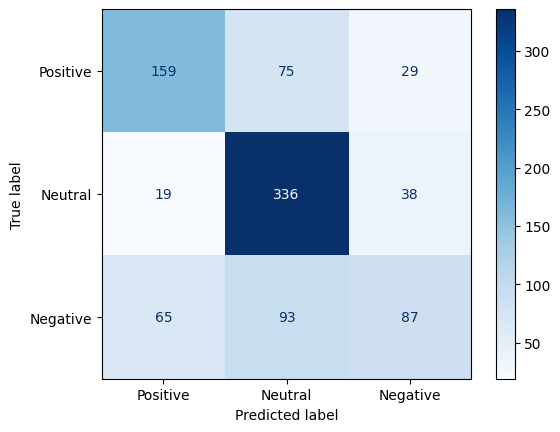

In [ ]:
# Predict the class probabilities for the test set
test_predictions = model_3_b.predict([X_test, test_pos_pad, test_data['aspect_encoded']])

# Convert the probabilities to class labels
test_pred_labels = test_predictions.argmax(axis=1)

# Convert test labels from one-hot encoded to class labels
test_true_labels = Y_test.argmax(axis=1)

# Generate the confusion matrix
cm_3_b = confusion_matrix(test_true_labels, test_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_3_b, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

29/29 [==============================] - 2s 30ms/step


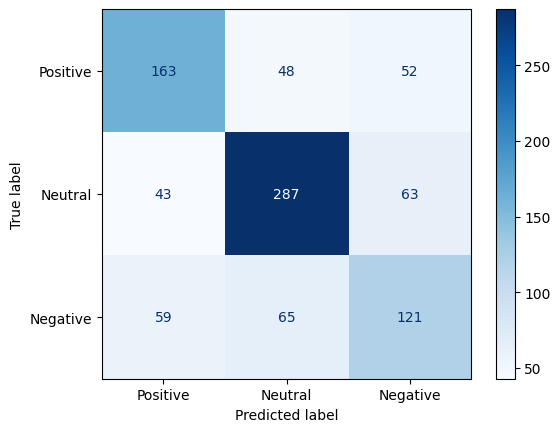

In [ ]:
# Predict the class probabilities for the test set
test_predictions = model_3_c.predict([X_test, test_pos_pad, test_data['aspect_encoded']])

# Convert the probabilities to class labels
test_pred_labels = test_predictions.argmax(axis=1)

# Convert test labels from one-hot encoded to class labels
test_true_labels = Y_test.argmax(axis=1)

# Generate the confusion matrix
cm_3_c = confusion_matrix(test_true_labels, test_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_3_c, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(cm_3_a)
print(cm_3_b)
print(cm_3_c)

[[153  67  43]
 [ 21 329  43]
 [ 60  93  92]]
[[159  75  29]
 [ 19 336  38]
 [ 65  93  87]]
[[163  48  52]
 [ 43 287  63]
 [ 59  65 121]]


###Ablation Study

29/29 [==============================] - 0s 14ms/step - loss: 0.9469 - accuracy: 0.6393
Model with LSTM validation Accuracy: 0.6392896771430969
29/29 [==============================] - 1s 21ms/step - loss: 0.9551 - accuracy: 0.6337
Model with validation with BiLSTM Accuracy: 0.6337403059005737
28/28 [==============================] - 1s 45ms/step - loss: 0.8694 - accuracy: 0.6453
Validation accuracy Model 2: 0.6452702879905701
29/29 [==============================] - 1s 33ms/step - loss: 0.7996 - accuracy: 0.6371
Validation accuracy: 0.6370699405670166
28/28 [==============================] - 2s 57ms/step - loss: 0.7977 - accuracy: 0.6543
Validation accuracy: 0.6542792916297913
28/28 [==============================] - 1s 24ms/step - loss: 0.8237 - accuracy: 0.6644
Validation accuracy: 0.6644144058227539


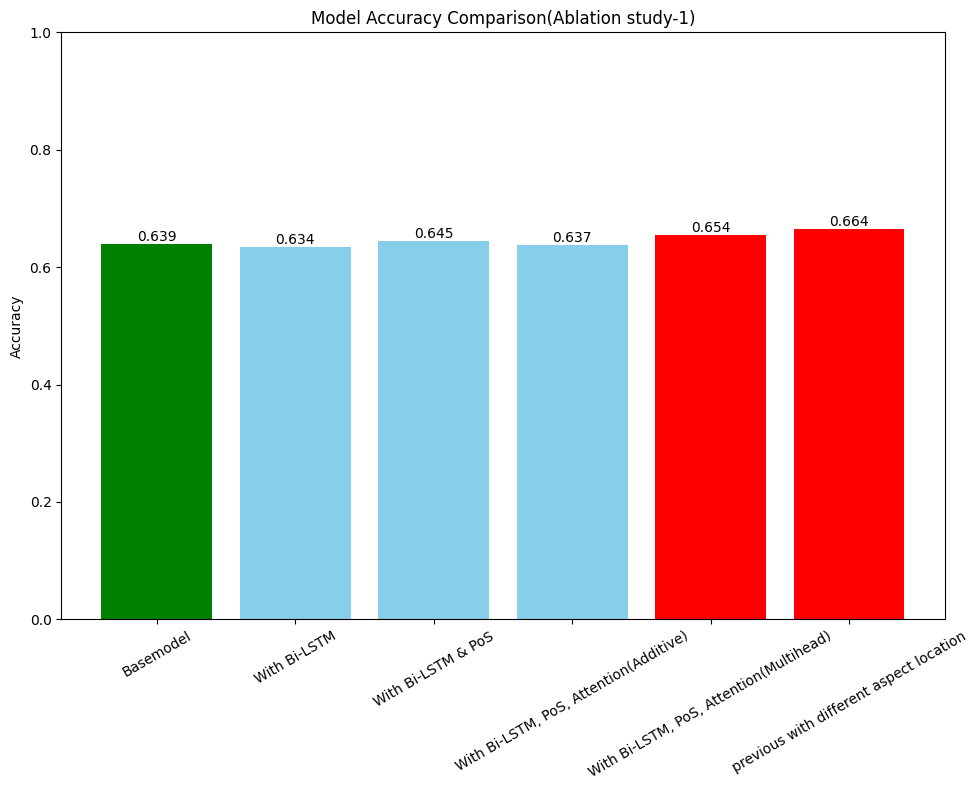

In [ ]:
model_lstm_validation_accuracy = model_1_baseline_lstm.evaluate([X_test, test_data['aspect_encoded']], Y_test)
print(f"Model with LSTM validation Accuracy: {model_lstm_validation_accuracy[1]}")

model_BiLSTM_validation_accuracy = model_1_baseline_BiLSTM.evaluate([X_test, test_data['aspect_encoded']], Y_test)
print(f"Model with validation with BiLSTM Accuracy: {model_BiLSTM_validation_accuracy[1]}")

val_accuracy_model_2 = model_2.evaluate([X_val, val_pos_pad, val_data['aspect_encoded']], Y_val)
print("Validation accuracy Model 2:", val_accuracy_model_2[1])
# Load the best model weights

# Evaluate the model on the test data
val_accuracy_3_a = model_3_a.evaluate([X_test, test_pos_pad, test_data['aspect_encoded']], Y_test)
print("Validation accuracy:", val_accuracy_3_a[1])

# Evaluate the model on the test data
val_accuracy_3_b = model_3_b.evaluate([X_val, val_pos_pad, val_data['aspect_encoded']], Y_val)
print("Validation accuracy:", val_accuracy_3_b[1])

# You need to provide the aspect data as well in the evaluation
val_accuracy_3_c = model_3_c.evaluate([X_val, val_pos_pad, val_data['aspect_encoded']], Y_val)
print("Validation accuracy:", val_accuracy_3_c[1])


models = [
    'Basemodel',
    'With Bi-LSTM',
    'With Bi-LSTM & PoS',
    'With Bi-LSTM, PoS, Attention(Additive)',
    'With Bi-LSTM, PoS, Attention(Multihead)',
    'previous with different aspect location'
]

accuracies = [model_lstm_validation_accuracy[1], model_BiLSTM_validation_accuracy[1], val_accuracy_model_2[1], val_accuracy_3_a[1], val_accuracy_3_b[1], val_accuracy_3_c[1]]


# Create the bar plot
plt.figure(figsize=(10, 8))  # Increase the figure size for better spacing
bars = plt.bar(models, accuracies, color=['green', 'skyblue', 'skyblue', 'skyblue', 'red', 'red'])

# Add accuracy labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom'
    )

plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
plt.xlabel('')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison(Ablation study-1)')
plt.xticks(rotation=30, ha='center')  # Rotate x-axis labels
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

In [ ]:
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences

# Define the model that will return the outputs needed for visualization
attention_extractor = Model(inputs=model_3_b.inputs, outputs=[model_3_b.output, model_3_b.get_layer('multi_head_attention').output])

def plot_attention_weights(test_sentences, tokenizer, pos_tokenizer, model, aspect_ids):
    # Tokenizing and padding text sequences
    text_sequences = tokenizer.texts_to_sequences(test_sentences)
    text_padded = pad_sequences(text_sequences, maxlen=max_len)

    # Assuming you have POS data for test sentences, tokenize and pad them as well
    test_pos_tags = add_pos_tags(test_sentences)  # Assumes a function like add_pos_tags exists
    pos_sequences = pos_tokenizer.texts_to_sequences(test_pos_tags)
    pos_padded = pad_sequences(pos_sequences, maxlen=max_len)

    # Prepare aspect input array
    aspect_input = np.array(aspect_ids)

    # Get predictions and attention weights from the model
    predictions, attention = model.predict([text_padded, pos_padded, aspect_input])

    # Visualization of attention weights
    for idx, sentence in enumerate(test_sentences):
        tokens = sentence.split()
        # Here we assume attention shape is [num_samples, sequence_length, num_heads] and we average over heads
        attention_weights = np.mean(attention[idx], axis=-1)
        plt.figure(figsize=(12, 2))
        sns.heatmap([attention_weights[:len(tokens)]], annot=[tokens], fmt="", cmap="Blues", cbar=True)
        plt.title(f"Attention Weights for: '{sentence}'")
        plt.xlabel("Token Position")
        plt.ylabel("Attention Weight")
        plt.show()

# Assuming 'test_data' is your DataFrame containing the test dataset
sample_indices = np.random.choice(test_data.index, size=2, replace=False)
sample_test_sentences = test_data.loc[sample_indices, 'sentence'].tolist()
sample_aspect_ids = test_data.loc[sample_indices, 'aspect_encoded'].tolist()

plot_attention_weights(sample_test_sentences, tokenizer, pos_tokenizer, attention_extractor, sample_aspect_ids)

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_simple_model(model, file_name):
    # Plot the model without showing layer names and shapes
    plot_model(model, to_file=file_name, show_shapes=False, show_layer_names=False)
    # Display the image in the notebook
    display(Image(file_name))



import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy.random import seed as set_random_seed

def plot_confusion_matrix(model, model_name, X_test_text, X_test_pos=None, X_test_aspect=None, y_test=None, class_names=None):

    # Make predictions based on model type
    if X_test_pos is not None and X_test_aspect is not None:
        y_pred = model.predict([X_test_text, X_test_pos, X_test_aspect])
    elif X_test_pos is not None:
        y_pred = model.predict([X_test_text, X_test_pos])
    else:
        y_pred = model.predict(X_test_text)

    # Convert probability predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Create a confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


##Experiments (Not required to run, helper functions)

In [ ]:
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adamax
from sklearn.metrics import accuracy_score
def build_base_model():
      vocab_size = len(tokenizer.word_index) + 1
      pos_vocab_size = len(pos_tokenizer.word_index) + 1
      word_embedding_dim = 100
      pos_embedding_dim = 30

      # Define the size of the aspect embedding
      aspect_embedding_dim = 30
      aspect_vocab_size = len(aspect_encoder.classes_)

      # Aspect Input and Embedding layer
      aspect_input = Input(shape=(1,))
      aspect_embedding = Embedding(aspect_vocab_size, aspect_embedding_dim, trainable=True)(aspect_input)
      aspect_embedding = Bidirectional(LSTM(64))(aspect_embedding)  # Using a simple LSTM to process aspect embeddings

      # Concatenating aspect embeddings with text and pos embeddings

      text_input = Input(shape=(max_len,))
      text_embedding = Embedding(vocab_size, word_embedding_dim, trainable=True)(text_input)
      text_lstm = Bidirectional(LSTM(64))(text_embedding)

      concat = concatenate([text_lstm, aspect_embedding])
      output = Dense(num_classes, activation='softmax')(concat)


      model_2_baseline = Model(inputs=[text_input, aspect_input], outputs=output)
      set_random_seed(112)

      return model_2_baseline

optimizers = {
    'Adam': Adam(),
    'RMSprop': RMSprop(),
    'Adagrad': Adagrad(),
    'Adamax': Adamax(),
    'SGD': SGD()
}

# Dictionary to store the results
results = {}

# Train and evaluate the model with each optimizer
for opt_name, opt in optimizers.items():
    print(f"Training with optimizer: {opt_name}")
    model_2_baseline = build_base_model()
    set_random_seed(112)
    model_2_baseline.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
        filepath=f'best_model_weights_{opt_name}.h5',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max',
        save_weights_only=True
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # Train the model
    history = model_2_baseline.fit(
        [X_train, train_data['aspect_encoded']], Y_train,
        validation_data=([X_val, val_data['aspect_encoded']], Y_val),
        epochs=10,
        batch_size=64,
        callbacks=[checkpoint, early_stopping]
    )

    # Evaluate the model
    best_model = build_base_model()
    best_model.load_weights(f'best_model_weights_{opt_name}.h5')
    set_random_seed(112)
    best_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    val_preds = best_model.predict([X_val, val_data['aspect_encoded']])
    val_preds_classes = np.argmax(val_preds, axis=1)
    val_true_classes = np.argmax(Y_val, axis=1)

    accuracy = accuracy_score(val_true_classes, val_preds_classes)
    results[opt_name] = accuracy

    print(f"Validation accuracy with {opt_name}: {accuracy:.4f}")

# Print the results
print("\nOptimizer Performance:")
for opt_name, accuracy in results.items():
    print(f"{opt_name}: {accuracy:.4f}")


